# Dates for Breakfast at the frat


In [1]:
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import yaml
# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from dateutil.relativedelta import relativedelta

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path, 'src'))

# Custom functions and classes
from utils import make_dates, create_folder

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['breakfast']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)

In [2]:
# Step 1: Load the data, convert to a proper datetime format and apply correction
merged_data = pd.read_csv(os.path.join(proj_path,
                                       catalog['output_dir']['dir'], 
                                       catalog['output_dir']['merged']))
merged_data['WEEK_END_DATE'] = pd.to_datetime(merged_data['WEEK_END_DATE'])
original_data = merged_data.copy()
merged_data['WEEK_END_DATE'] = merged_data['WEEK_END_DATE'] + timedelta(days=3)

# Step 2: Create date folds
date_ranges = make_dates(params['breakfast']['experiment_dates'])

In [3]:
date_ranges

,train_start,train_end,valid_start,valid_end,test_start,test_end
0,2009-01-17,2010-12-04,2010-12-11,2011-01-01,2011-01-08,2011-01-29
1,2009-02-14,2011-01-01,2011-01-08,2011-01-29,2011-02-05,2011-02-26
2,2009-03-14,2011-01-29,2011-02-05,2011-02-26,2011-03-05,2011-03-26
3,2009-04-11,2011-02-26,2011-03-05,2011-03-26,2011-04-02,2011-04-23
4,2009-05-09,2011-03-26,2011-04-02,2011-04-23,2011-04-30,2011-05-21
5,2009-06-06,2011-04-23,2011-04-30,2011-05-21,2011-05-28,2011-06-18
6,2009-07-04,2011-05-21,2011-05-28,2011-06-18,2011-06-25,2011-07-16
7,2009-08-01,2011-06-18,2011-06-25,2011-07-16,2011-07-23,2011-08-13
8,2009-08-29,2011-07-16,2011-07-23,2011-08-13,2011-08-20,2011-09-10
9,2009-09-26,2011-08-13,2011-08-20,2011-09-10,2011-09-17,2011-10-08


# Methodology

The start date of the experiment is 2009-01-17 and the end date of the experiment is 2011-12-31.  

We will use the last 52 weeks as our test data, covering inclusively the dates from 2011-01-08 to 2011-12-31.  

Will will use sequences of 4 weeks to create our cross-validation folds over the test period.  Bollow is an illustration for the different folds.  

In [4]:
def show_windows(dates: pd.DataFrame, fname=None):
    """Generate a plot to view the time of the different folds.
    
    fname to save plot, specify a path.
    """
    # Register a date converter from pandas to work with matplotlib
    register_matplotlib_converters()

    mi = dates["train_start"].min() - relativedelta(weeks=1)
    ma = dates["test_end"].max() + relativedelta(weeks=1)

    plt.figure(figsize=(16, 5))
    plt.scatter(x=[mi, ma], y=[0, 0], alpha=0)
    for i, date_range in enumerate(dates.sort_values("train_start").itertuples()):

        # Width of bar in days
        train_len = (date_range[3] - date_range[1]).days
        valid_len = (date_range[4] - date_range[2]).days
        test_len = (date_range[6] - date_range[4]).days

        plt.barh(y=i, width=train_len, left=date_range[1], color="#C5CAE9")
        plt.barh(y=i, width=valid_len, left=date_range[3], color="#2196F3")
        plt.barh(y=i, width=test_len, left=date_range[5], color="#1A237E")
        plt.xticks(rotation=45)
        plt.xlabel("Dates")
        plt.ylabel("Fold Id")

    plt.title("Cross-Validation Through Time")
    plt.legend(["", "Train period", "Valid period", "Test period"])
    if fname:
        plt.savefig(fname)
    plt.show()

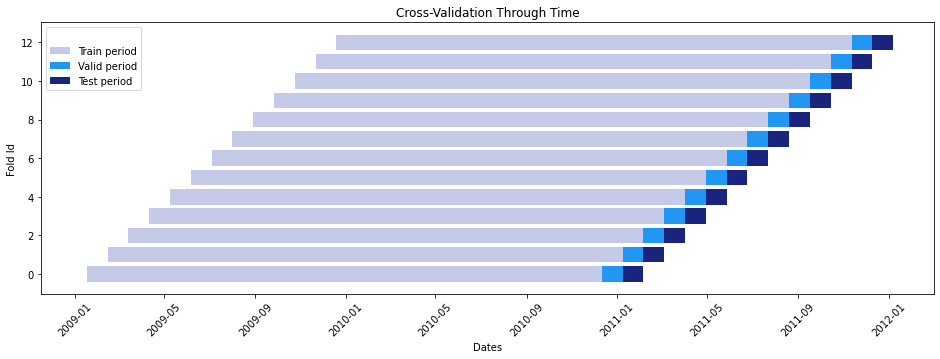

In [5]:
show_windows(date_ranges)

Breakfast at the frat uses wednesdays to represent their end of week sales. Thus, we need to add + 3 days to get the actual end of week dates. By end of week, we will specify "Saturdays".  

This means that when the dates of the Breakfast at the frat indicates that the sales units are on this date:
Saturday 2010-12-11. We do not want any leakage, hence we will only use the sales from Saturday 2010-12-04.  

For Google Trends, when extracting the hits, they return the begining of week dates that cover the hits from Sunday to Saturday. However, it is best to use the end-of-week to match with Breakfast at the frat. Thus, we add 6 days to the dates for them to align. In fact, we only get the end of week google trends hits at the end of a week, so on Saturdays, we get the hits that cover from previous Sunday up to that Saturday. To link with the previous example, the Google Trends hits that covers from Sunday 2010-12-05 to Saturday 2010-12-11, cannot be used to predict the sales of Saturday 2010-12-11. We need to use the Google trends hits from the previous week.